In [1]:
import nltk
import numpy as np
from multiprocessing import Process
from multiprocessing import Manager
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt
import pickle
#!pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0.tar.gz

[nltk_data] Downloading package punkt to /home/maximus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Данные

In [2]:
df_data = pandas.read_csv("../data/Dude_tinkoff_new.csv") 

In [3]:
df_data.head()

,Unnamed: 0,author_id,author_url,author_name,text,reply_count,top_level,index,publishedAt,updateAt,likeCount
0,0,UC2yzgGYTEDdRNVkayjW1C2w,http://www.youtube.com/channel/UC2yzgGYTEDdRNV...,Владимир Виноградов,"Вот и до Яндекса добрались. \nЮрий Д., пора Ар...",0,0.0,0.0,2022-12-11T16:37:04Z,2022-12-11T16:37:04Z,0.0
1,1,UCg9iwvHlL3awmOHNHsBFEUA,http://www.youtube.com/channel/UCg9iwvHlL3awmO...,Dmitry Gaskov,"А где пометка ""На правах рекламы""?",0,0.0,1.0,2022-12-11T09:51:29Z,2022-12-11T09:51:29Z,0.0
2,2,UCdMwli0sTZ8jgLYXHTVZ8Gg,http://www.youtube.com/channel/UCdMwli0sTZ8jgL...,Sveta Teryoshkina,"Олег, живите! Вы крутой человек! Аминь!",0,0.0,2.0,2022-12-11T06:30:14Z,2022-12-11T06:30:14Z,1.0
3,3,UCBHQrudnNCELvzFu9NYADmA,http://www.youtube.com/channel/UCBHQrudnNCELvz...,Irina Bychal,"Спасибо за интервью, за адекватность.Тоже не м...",0,0.0,3.0,2022-12-11T05:51:37Z,2022-12-11T05:51:37Z,1.0
4,4,UCCZT1uuGwvTX45qOH6WgpSg,http://www.youtube.com/channel/UCCZT1uuGwvTX45...,Александр Носов,Молодец во всем! Но кажется что он запутался к...,0,0.0,4.0,2022-12-10T20:48:15Z,2022-12-10T20:48:15Z,0.0


In [4]:
df_data.shape

(93339, 11)

In [5]:
df_data["text"] = df_data["text"].astype('str')

In [6]:
df_data = df_data.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91809 entries, 0 to 93338
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   91809 non-null  object 
 1   author_id    91809 non-null  object 
 2   author_url   91809 non-null  object 
 3   author_name  91809 non-null  object 
 4   text         91809 non-null  object 
 5   reply_count  91809 non-null  object 
 6   top_level    91809 non-null  float64
 7   index        91809 non-null  float64
 8   publishedAt  91809 non-null  object 
 9   updateAt     91809 non-null  object 
 10  likeCount    91809 non-null  float64
dtypes: float64(3), object(8)
memory usage: 8.4+ MB


In [7]:
df_data[df_data["author_name"].isnull()]["Unnamed: 0"][:3]

Series([], Name: Unnamed: 0, dtype: object)

## Выделение пользователей, которые часто оставляют комменатрии

In [8]:
d = df_data.groupby(by=["author_id"], dropna=False).agg(full_text =("text","sum"), count=("author_id","count"))

Будем использовать только пользователей, которые часто комментируют (более 5 раз)

In [9]:
res = d.sort_values(by="count", ascending=False)
res = res[res["count"]>2]

In [10]:
res[res["count"]>=3]["count"].sum()

22661

In [11]:
auth = set(res.index.to_list())

In [12]:
df = df_data.copy()
#df = df.drop(df["author_id"].isin(delete_auth).index)
df = df.loc[df["author_id"].isin(auth)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22661 entries, 7 to 93270
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   22661 non-null  object 
 1   author_id    22661 non-null  object 
 2   author_url   22661 non-null  object 
 3   author_name  22661 non-null  object 
 4   text         22661 non-null  object 
 5   reply_count  22661 non-null  object 
 6   top_level    22661 non-null  float64
 7   index        22661 non-null  float64
 8   publishedAt  22661 non-null  object 
 9   updateAt     22661 non-null  object 
 10  likeCount    22661 non-null  float64
dtypes: float64(3), object(8)
memory usage: 2.1+ MB


In [13]:
train_corpus = df["text"]

## Токенизация комментариев 

In [14]:
tokenized_text = [word_tokenize(tok) for tok in train_corpus]

In [15]:
tokens_filtered = [word for sent in tokenized_text for word in sent if word.isalnum()]

In [16]:
len(tokens_filtered)

597520

In [17]:
max_words = 20
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [18]:
dist

FreqDist({'и': 19383, 'не': 15249, 'в': 13862, 'что': 9521, 'br': 7535, 'на': 6934, 'это': 5332, 'с': 4984, 'а': 4749, 'как': 4569, ...})

## Препроцессинг (Лематизация, удаление стоп-слов)

In [19]:
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [20]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words.extend(['br', 'її', 'quot', 'www', 'href', 'https', 'http', 'ru'])
stop_words.extend(stopwords.words('english'))

In [21]:
stop_words;

In [22]:
bigram = gensim.models.Phrases(tokenized_text, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_text], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [23]:
#from nltk.stem import WordNetLemmatizer
#wnl = WordNetLemmatizer()
import spacy
nlp = spacy.load("ru_core_news_sm")

def lemma(word):
    for w in nlp(word):
        return w.lemma_
def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([lemma(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


/home/maximus/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [24]:
data_ready = process_words(tokenized_text)  # processed Text Data!
#with open("tinkoff_corpus_preprocess.bin", 'rb') as f:
#    data_ready = pickle.load(f)

In [25]:
#with open("tinkoff_corpus_preprocess.bin", 'wb') as f:
#    pickle.dump(data_ready, f)

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [27]:
#stopd_words = ['br', 'її', 'quot' 'www', 'href']
#data_ready   

In [28]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                          # update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True, workers=2)


## Распределение для тем

In [29]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.058*"олег" + 0.047*"интервью" + 0.033*"тебе" + 0.027*"сделать" + '
  '0.019*"банк" + 0.019*"здоровье" + 0.018*"видеть" + 0.017*"ещё" + '
  '0.012*"интересный" + 0.012*"посмотреть"'),
 (1,
  '0.019*"это" + 0.013*"сарказм" + 0.012*"император" + 0.012*"поэтому" + '
  '0.011*"хуже" + 0.011*"выпуск" + 0.010*"сразу" + 0.010*"забрать" + '
  '0.009*"право" + 0.009*"понятный"'),
 (2,
  '0.074*"человек" + 0.050*"это" + 0.022*"тиньков" + 0.016*"просто" + '
  '0.016*"юра" + 0.014*"мочь" + 0.014*"деньга" + 0.012*"очень" + 0.011*"дудь" '
  '+ 0.011*"убийца"'),
 (3,
  '0.061*"youtu" + 0.036*"жить" + 0.032*"сказать" + 0.031*"спасибо" + '
  '0.028*"вообще" + 0.023*"хороший" + 0.018*"давать" + 0.014*"ник" + '
  '0.014*"сайт" + 0.014*"тинькофф"'),
 (4,
  '0.028*"герой" + 0.026*"маньяк_убийца" + 0.026*"жертва" + 0.024*"молодец" + '
  '0.024*"переобуться" + 0.018*"пример" + 0.015*"топ" + 0.011*"жопа" + '
  '0.010*"продажный" + 0.010*"часть_присяжных"'),
 (5,
  '0.033*"жизнь" + 0.025*"мир" + 0.022

In [30]:
N = 409
print("Prob theme in the document: ", lda_model.get_document_topics(corpus[N]))
print("Text: ", d["full_text"][N])

Prob theme in the document:  [(0, 0.020722523), (1, 0.020722486), (2, 0.1870348), (3, 0.45323056), (4, 0.020723391), (5, 0.020722628), (6, 0.020722907), (7, 0.2561207)]
Text:  Через него хотят бабки отмывать.Постанова.Видно же каждую минуту,как он пиздит 🤦‍♂️


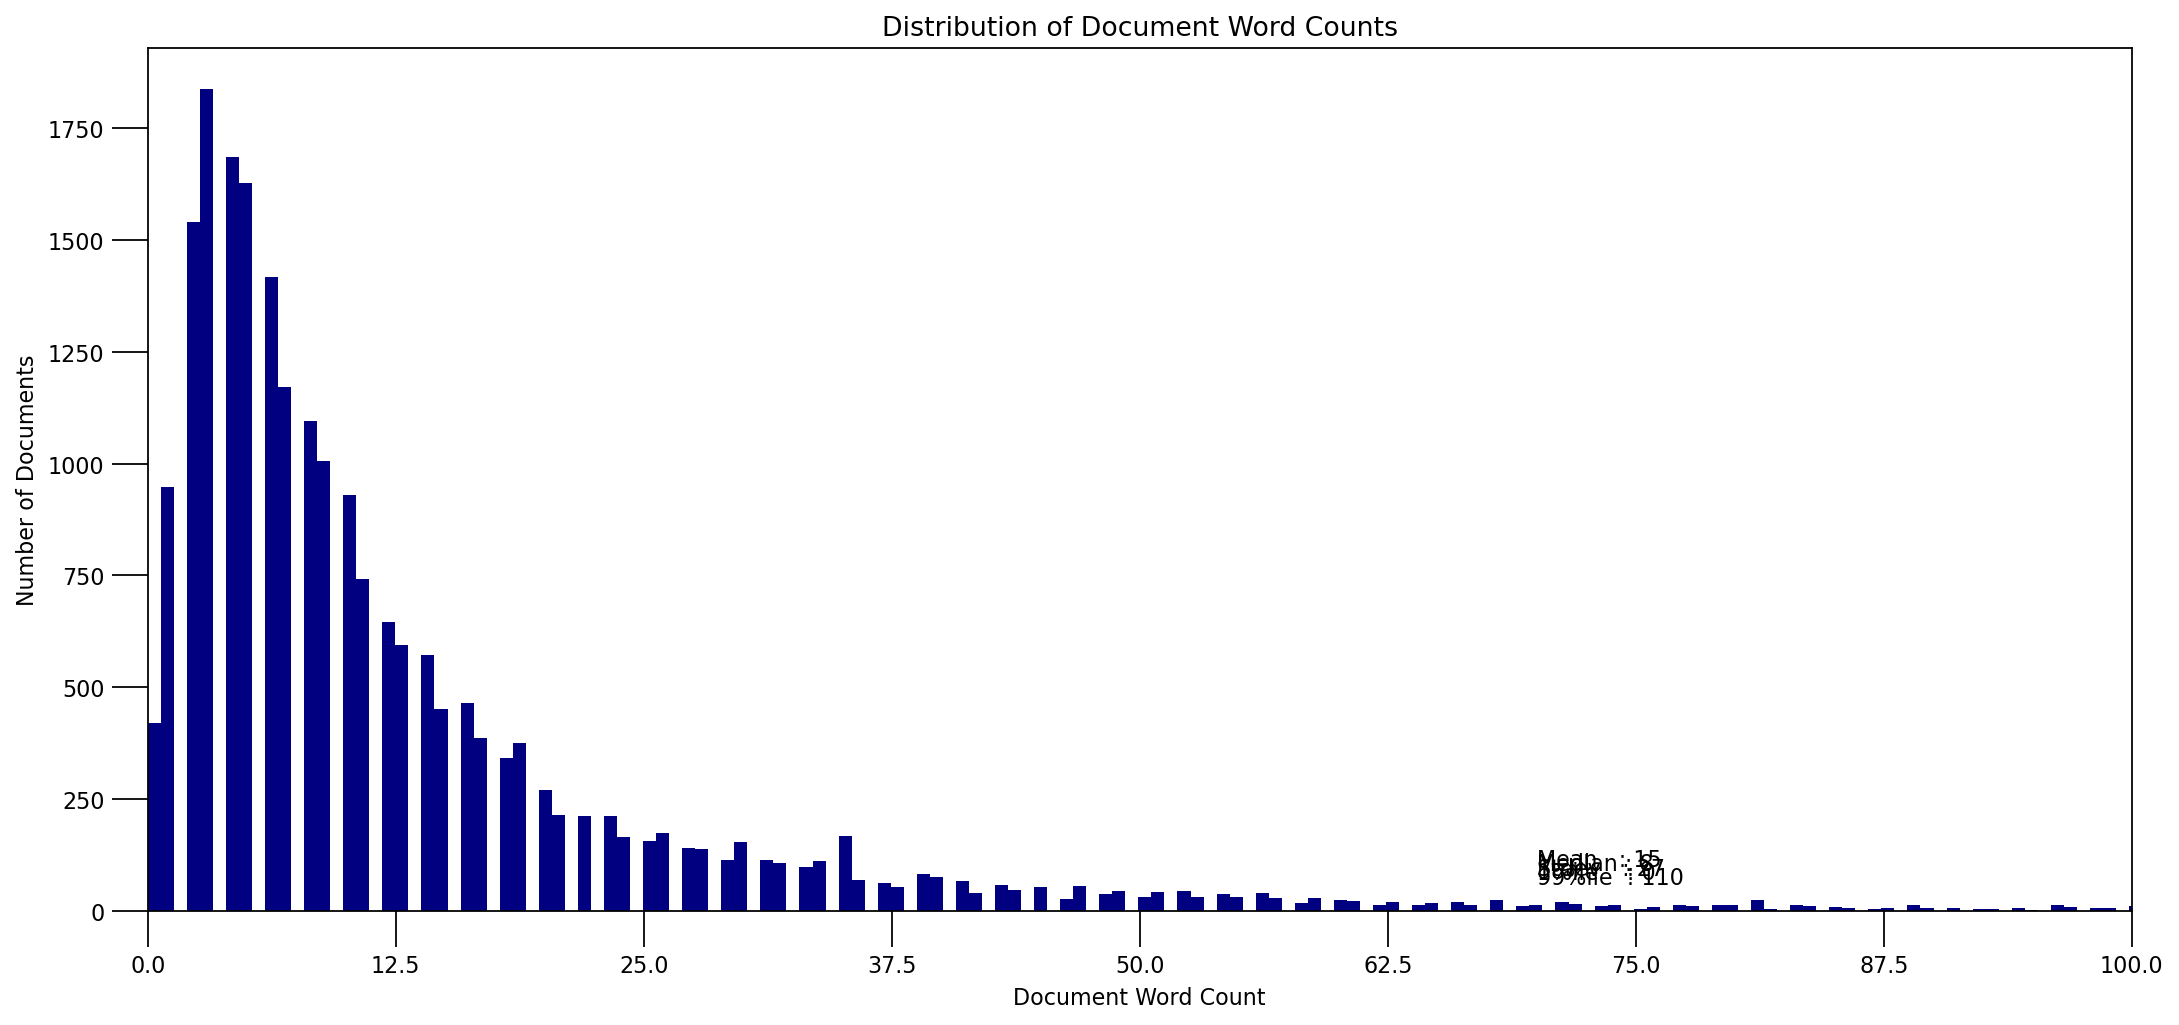

In [31]:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts')
plt.show()

In [32]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

/tmp/ipykernel_57904/3602903778.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_57904/3602903778.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_57904/3602903778.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_57904/3602903778.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_57904/3602903778.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_57904/360290377

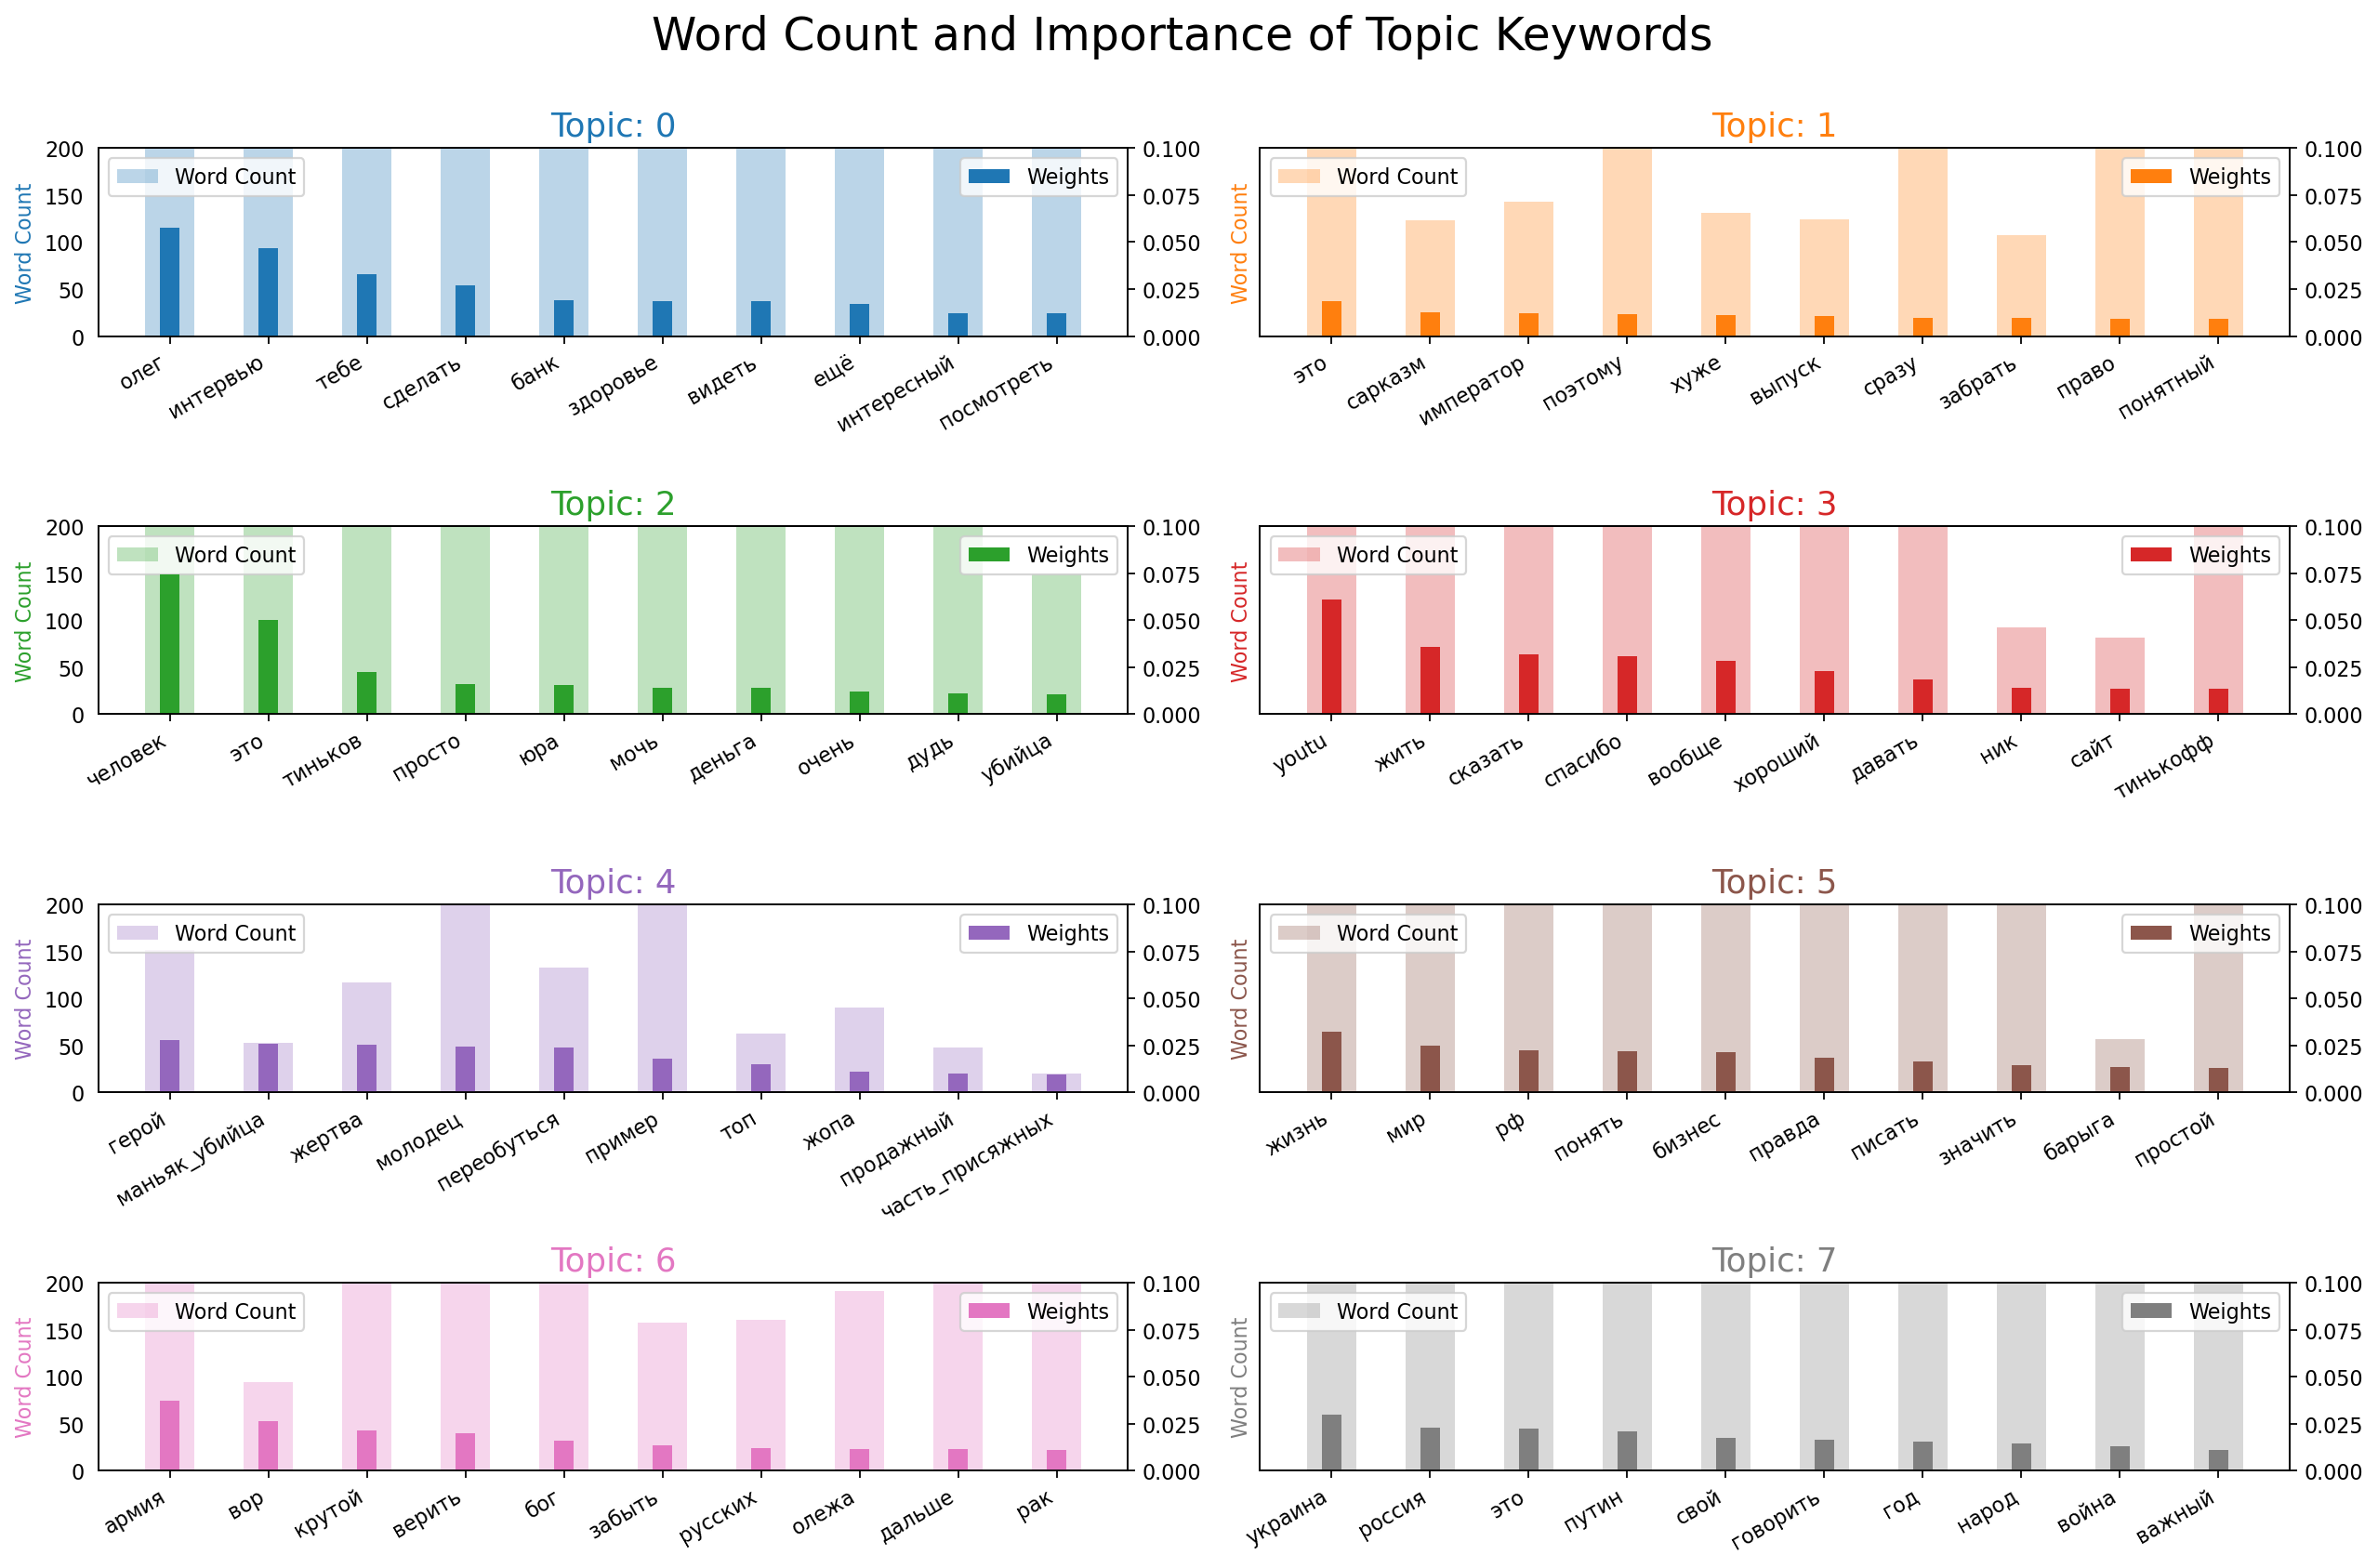

In [33]:
# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors

fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()
fig.savefig("../Report/pics/themes.png")

In [34]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()
    return fig

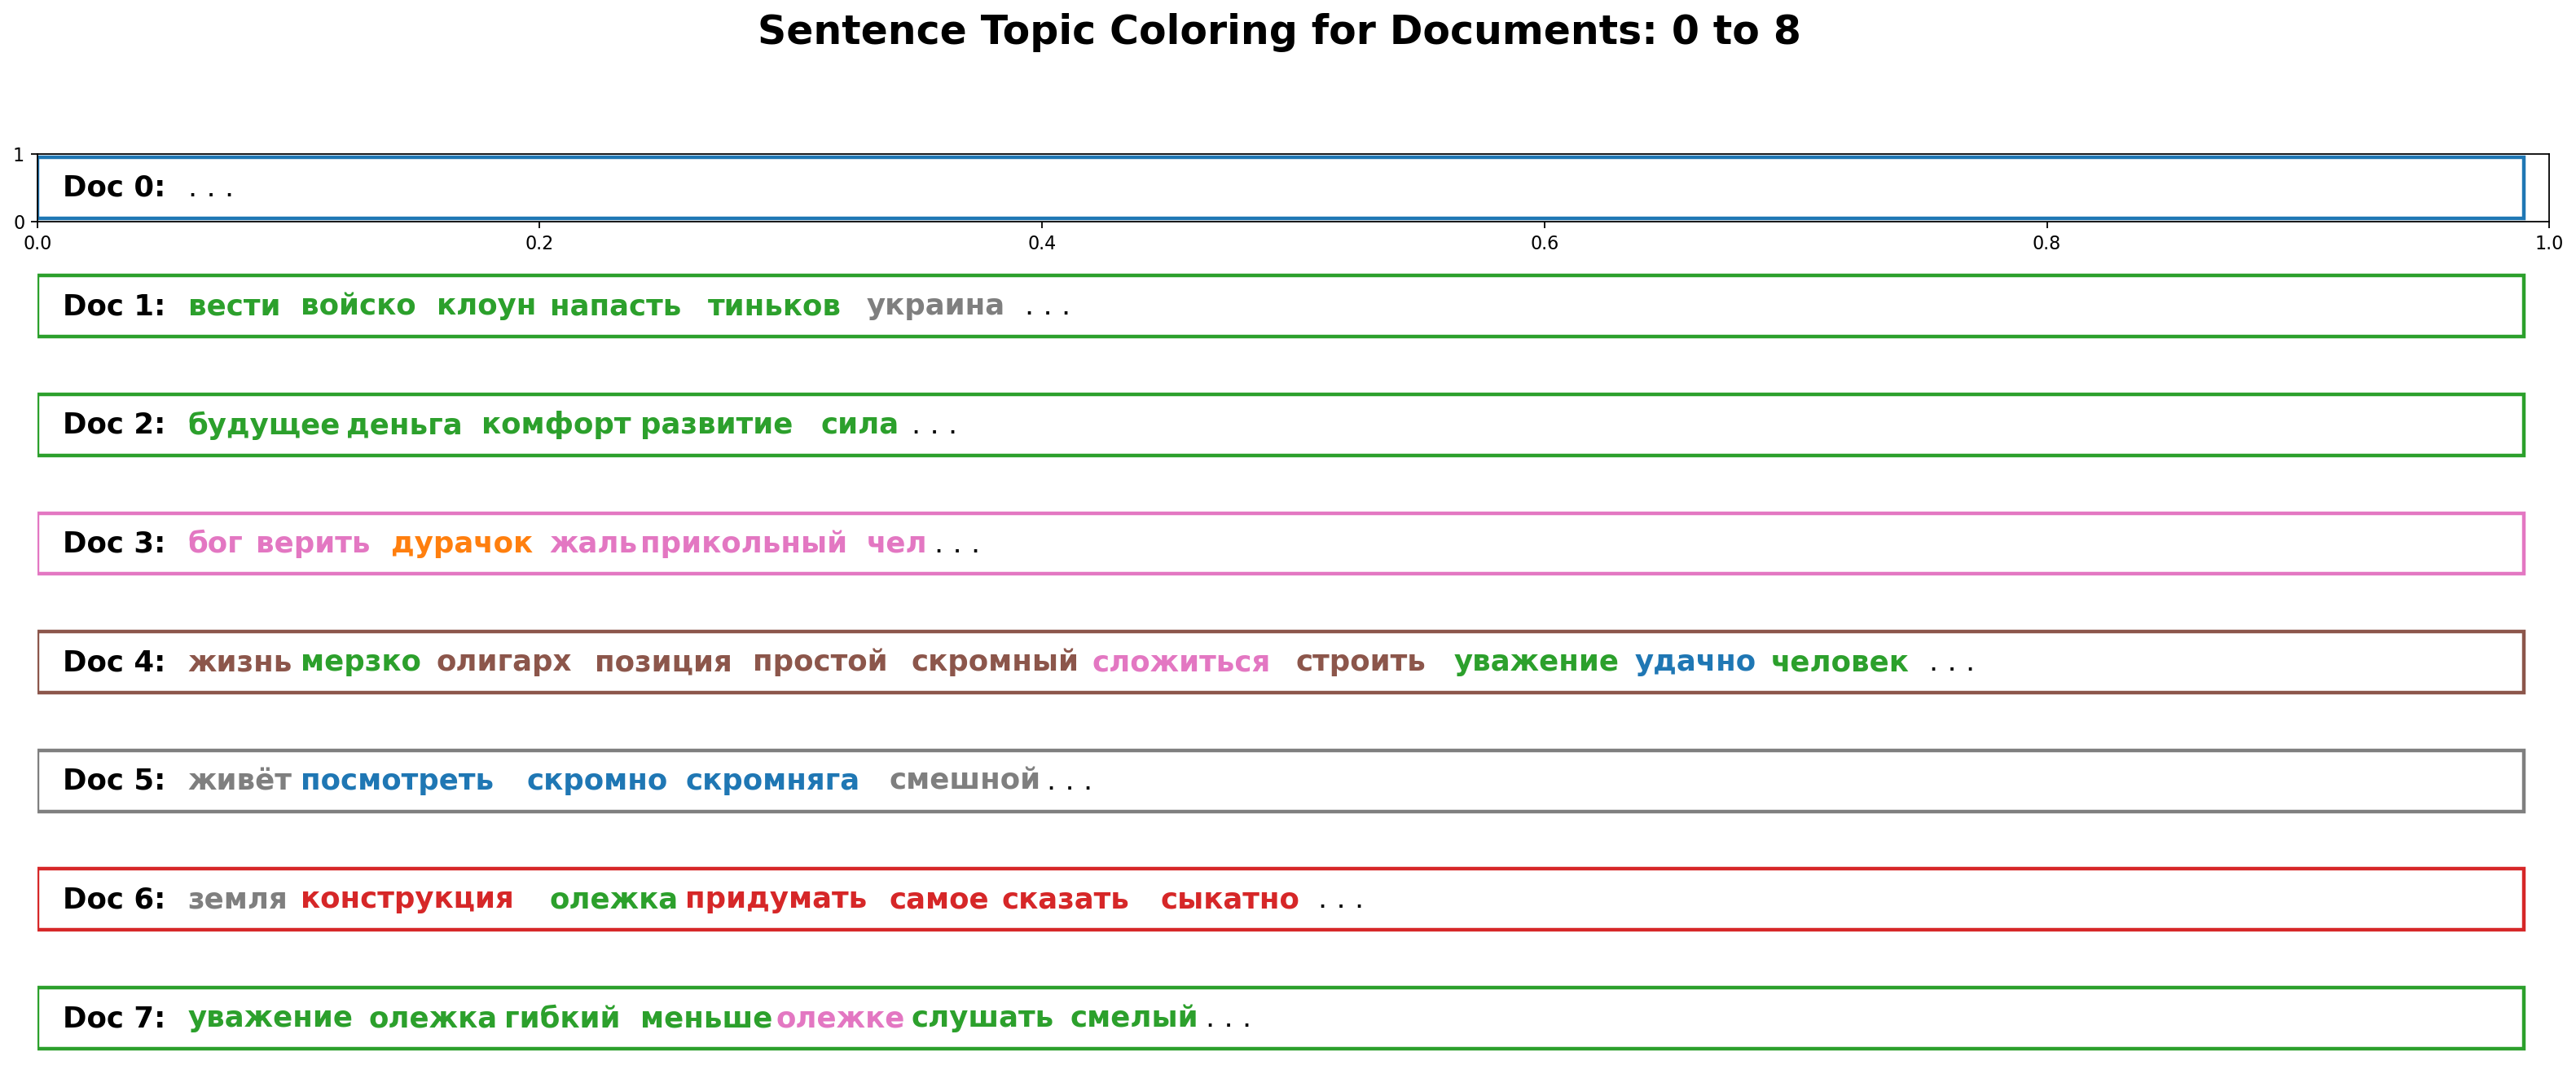

In [42]:
fig = sentences_chart(start=0, end=9)  
fig.savefig("../Report/pics/colored_text.png")

In [36]:
#mycolors

In [37]:
class_pred = np.zeros(len(corpus))
for i,doc in enumerate(corpus):
    prob = lda_model.get_document_topics(doc)
    index = np.argmax(np.array(prob)[:,1])
    class_pred[i] = index
    #print(np.array(prob)[:,1])

(array([2891., 2252., 4871.,    0., 2527., 2056.,    0., 2195., 1608.,
        4261.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

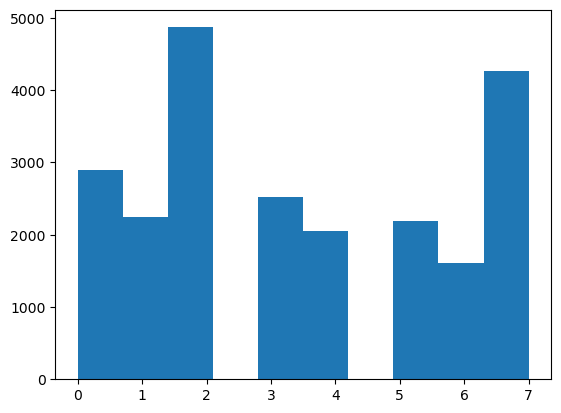

In [38]:
plt.hist(class_pred)

In [43]:
#for w in train_corpus[class_pred==4]:
#    print(w)
#    print('-----------------------------------------')

In [44]:
class_with_noise = 4
n = train_corpus.iloc[class_pred==class_with_noise].shape[0]
print("Number element in cluster (LDA): ", n)

Number element in cluster (LDA):  2056


In [45]:
import codecs
LINE_WIDTH = 80
sub_indexes = np.random.randint(0,n,10)
with codecs.open("../Report/ldaclasscomment.txt","w","utf-8-sig") as f:
    #f.write("\\begin{verbatim}")
    for w in train_corpus.iloc[class_pred==class_with_noise].iloc[sub_indexes]:
        print(w)
        print("----------------------------------\n")
        f.write((w[:LINE_WIDTH] + "...\n"))
        f.write("-------------------------------------------\n")

☝ To caмoе Mлaдше !7 в Huкe 👆
----------------------------------

@NekoSoul EngMafaka Революція Гідності це дуже крута штука, і якби її не було, то її б слід було вигадати. Нам дуже пощастило напевно, що ми пройшли саме такий шлях, який пройшли. Хоча важко це усвідомити враховуючи Небесну сотню, загиблих у війні на Донбасі і при повномасштабному вторгненні. Звісно мені легко писати, так як не я і не мої близькі були серед загиблих. Революція гідності це навіть не про усунення диктатора і корупції, хоча і про це теж. Вона просвітила українців. Відкрила вже остаточно очі. До 2014 всім (більшості) було байдуже, якою мовою в нас телебачення, чому в нас стоїть пам’ятник Леніну, чому ми святкуємо 23 лютого, і 9 травня до речі теж. Всі ми жили у дружбі з Росією, тією самою яка ще 23 роки тому забороняла нам нашу церкву, мову, історію і будь-який опір, який би призвів до незалежності України. Сьогодні подивитись в 1991 рік, то було би суперово, якби Революція Гідності пройшла в 1991 році. А то

Таблица для сбора общей статистики.

In [50]:
df_stat = pandas.read_csv("total_stat.csv", index_col=0) 
#df_auth_stat = 

Таблица для сбора общей статистики по авторам.

In [73]:
df_auth_stat = pandas.read_csv("total_auth_stat.csv", index_col=0) 

In [74]:
df_stat = df_stat.append({'models':'lda', 'class_size':n},ignore_index=True)

/tmp/ipykernel_57904/871945399.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_stat = df_stat.append({'models':'lda', 'class_size':n},ignore_index=True)


In [75]:
df_stat

,models,class_size
0,total,22661
1,GMM,976
2,out_circle,503
3,kmeans,413
4,lda,2056
5,lda,2056


In [55]:
train_corpus.shape

(22661,)

In [58]:
df_stat.to_latex("../Report/total_table.tex", index=False) 
    
    

/tmp/ipykernel_57904/3605853762.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_stat.to_latex("../Report/total_table.tex", index=False)


In [66]:
df.iloc[class_pred==class_with_noise]["author_id"].unique().shape

(1281,)

In [67]:
df_auth_stat = pandas.DataFrame(columns=['models', 'number_of_authors'])

In [79]:
n_a = df.iloc[class_pred==class_with_noise]["author_id"].unique().shape[0]
df_auth_stat = df_auth_stat.append({'models':'lda', 'number_of_authors':n_a},ignore_index=True)

/tmp/ipykernel_57904/52390924.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_auth_stat = df_auth_stat.append({'models':'lda', 'number_of_authors':n_a},ignore_index=True)


In [72]:
df["author_id"].unique().shape[0]

4267

In [81]:
df_auth_stat.to_latex("../Report/total_auth_table.tex", index=False)

/tmp/ipykernel_57904/1935272556.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_auth_stat.to_latex("../Report/total_auth_table.tex", index=False)


In [80]:
df_auth_stat

,models,number_of_authors
0,total,4267
1,GMM,319
2,out_circle,61
3,kmeans,255
4,lda,1281
